In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd 
import numpy as np
import random
import math
result = pd.read_csv('../data/1_before2016.csv').dropna()
data = result.drop('meanest', axis=1)
x = data.drop('actual', axis=1)
mean_normal = np.mean(x, axis=0)
std_normal = np.std(x, axis=0)
data.loc[:, 'actq':'fincfy'] = (x - mean_normal)/std_normal

seq = []
for name, content in data.groupby('tic'):
    for i in range(len(content.index)-6):
        train_seq = []
        train_label = []
        for j in range(i, i + 6):
            x = content.iloc[j]['actq':'actual']
            train_seq.append(x)
        train_seq.append(content.iloc[i+6]['actq':'fincfy'].append(pd.Series([0])))
        train_label.append(content.iloc[i+6]['actual'])
        train_seq = torch.FloatTensor(train_seq)
        train_label = torch.FloatTensor(train_label).view(-1)
        seq.append((train_seq, train_label))


result1 = pd.read_csv('../data/1_after2016.csv').dropna()
data1 = result1.drop('meanest', axis=1)
x1 = data1.drop('actual', axis=1)
data1.loc[:, 'actq':'fincfy'] = (x1 - mean_normal)/std_normal

seq1 = []
for name, content in data1.groupby('tic'):
    for i in range(len(content.index)-6):
        train_seq = []
        train_label = []
        for j in range(i, i + 6):
            x = content.iloc[j]['actq':'actual']
            train_seq.append(x)
        train_seq.append(content.iloc[i+6]['actq':'fincfy'].append(pd.Series([0])))
        train_label.append(content.iloc[i+6]['actual'])
        train_seq = torch.FloatTensor(train_seq)
        train_label = torch.FloatTensor(train_label).view(-1)
        seq1.append((train_seq, train_label))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3417: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3558: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return std

In [2]:
N = len(seq)
random.shuffle(seq)
train_N = (int(N/64)-20) * 64
valid_N = N - train_N

In [3]:
train_seq = [ seq[i] for i in range(0, train_N)]
valid_seq = [ seq[i] for i in range(train_N, len(seq))]

In [4]:
len(train_seq), len(valid_seq)

(18368, 1337)

In [5]:
train_loader = torch.utils.data.DataLoader(dataset=train_seq, batch_size=128, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_seq, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=seq1, batch_size=50000, shuffle=True)

In [6]:
device = 'cpu'
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, batch_size, output_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_directions = 1 
        self.batch_size = batch_size
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.reg = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, input_seq):
        # output(batch_size, seq_len, num_directions * hidden_size)
        output, _ = self.lstm(input_seq) # output(64, 6, 20)
        output = output[:, -1, :]
        output = output.view(-1, self.hidden_size)  # (64, 20)
        output = self.reg(output)
        return output

In [7]:
def withinten(y_true, y_pred):
    sum1 = 0
    for i in range(len(y_pred)):
        if(y_pred[i] < 1.1*y_true[i] and y_pred[i] > 0.9*y_true[i]):
            sum1+=1
    return sum1/len(y_pred)

In [8]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
trainloss = []
validloss = []

def train(args, model, device, train_loader, valid_loader, log_interval=100):
    model = model.to(device)

    loss_function = nn.MSELoss(reduction='mean').to(device)
    if args['optimizer'] == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=args['lr'], momentum=0.9)
    
    # training
    for epoch in range(args['epoch']):
        loss1 = 0
        for batch_idx, (seq, label) in enumerate(train_loader):
            seq = seq.to(device)
            label = label.to(device)
            y_pred = model(seq)
            loss = loss_function(y_pred, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss1 += loss.item() * len(y_pred)
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(seq), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
        trainloss.append(loss1/train_N)

        model.eval()
        with torch.no_grad():
            loss = 0
            for (data, target) in valid_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss += loss_function(output, target).item() * len(output)
        validloss.append(loss/valid_N)
        print('Valid Loss: {:.3f}\n'.format(loss/valid_N))


def test(model, device, test_loader):
    model.eval()
    loss_function = nn.MSELoss(reduction='mean').to(device)
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = loss_function(output, target).item()
            r2_nn0 = r2_score(target, output)
            within10 = withinten(target, output)
    return loss, r2_nn0, within10


In [9]:
model = LSTM(11, 20, 1, 128, 1)

In [10]:
args = {'optimizer': 'adam',
        'lr': 0.01,
        'epoch': 200}
train(args, model, device, train_loader, valid_loader)

Train Epoch: 0 [0/18368 (0%)]	Loss: 1.118543
Train Epoch: 0 [12800/18368 (69%)]	Loss: 0.082943
Valid Loss: 0.172

Train Epoch: 1 [0/18368 (0%)]	Loss: 0.065283
Train Epoch: 1 [12800/18368 (69%)]	Loss: 0.162717
Valid Loss: 0.158

Train Epoch: 2 [0/18368 (0%)]	Loss: 0.098679
Train Epoch: 2 [12800/18368 (69%)]	Loss: 0.325209
Valid Loss: 0.155

Train Epoch: 3 [0/18368 (0%)]	Loss: 0.063750
Train Epoch: 3 [12800/18368 (69%)]	Loss: 0.104504
Valid Loss: 0.149

Train Epoch: 4 [0/18368 (0%)]	Loss: 0.358552
Train Epoch: 4 [12800/18368 (69%)]	Loss: 0.063469
Valid Loss: 0.126

Train Epoch: 5 [0/18368 (0%)]	Loss: 0.055666
Train Epoch: 5 [12800/18368 (69%)]	Loss: 0.044221
Valid Loss: 0.122

Train Epoch: 6 [0/18368 (0%)]	Loss: 0.037541
Train Epoch: 6 [12800/18368 (69%)]	Loss: 0.153847
Valid Loss: 0.114

Train Epoch: 7 [0/18368 (0%)]	Loss: 0.103360
Train Epoch: 7 [12800/18368 (69%)]	Loss: 0.256411
Valid Loss: 0.104

Train Epoch: 8 [0/18368 (0%)]	Loss: 0.047747
Train Epoch: 8 [12800/18368 (69%)]	Loss: 0.

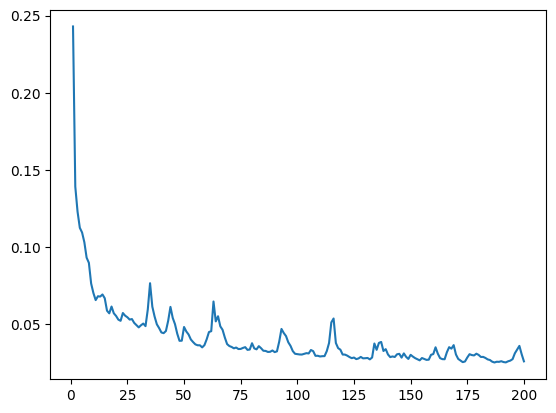

In [11]:
from matplotlib import pyplot as plt
plt.plot(range(1, 200+1), trainloss)
#plt.savefig('lstm2_train_improve.png')

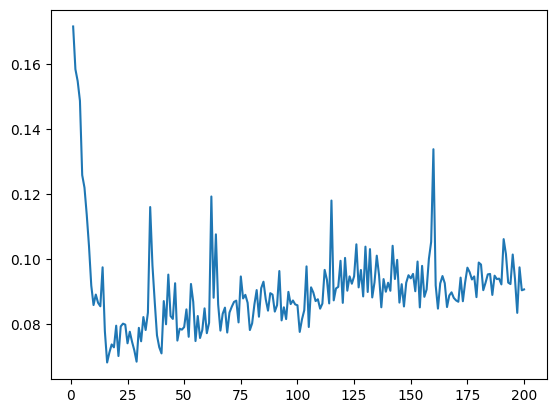

In [12]:
plt.plot(range(1, 200+1), validloss)
#plt.savefig('lstm2_valid_improve.png')

In [16]:
lossi, r2i, within10i = test(model, device, test_loader)

print('Test Loss: {:.3f}'.format(lossi))
print('R2: {:.3f}'.format(r2i))
print('Within10%: {:.3f}'.format(within10i))

Test Loss: 1.453
R2: 0.544
Within10%: 0.311
